In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras

%matplotlib inline
import sys

import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential

sys.path.append("..")

In [2]:
img_rows, img_cols = 28, 28
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255.0
x_test /= 255.0
y_train = keras.utils.to_categorical(y_train_)
y_test = keras.utils.to_categorical(y_test_)

In [3]:
model = Sequential()
model.add(Dense(500, activation="relu"))
model.add(Dense(10, activation="softmax"))

2022-03-31 16:04:50.291244: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model.compile("adam", "categorical_crossentropy", metrics=["acc"])

In [5]:
model.fit(x_train, y_train, validation_split=0.2, batch_size=32, epochs=1, verbose=0)

In [6]:
# model.save_weights('tuto_4_ongoing.hd5')

In [7]:
model.evaluate(x_train, y_train)

1875/1875 [==============================] - 2s 1ms/step - loss: 0.1030 - acc: 0.9696


[0.10296569019556046, 0.9695666432380676]

In [8]:
model.predict(x_train[:1]).argmax()

5

In [9]:
from decomon.models import clone

In [10]:
from decomon import get_adv_box

In [11]:
eps = 0.1
X_train = x_train
X_train_min = X_train - eps
X_train_max = X_train + eps
Y_train = y_train
B_train = np.concatenate([X_train_min[:, None], X_train_max[:, None]], 1)

In [12]:
back_bounds = Input((10, 10))

In [13]:
decomon_nnet = clone(model, method="crown-ibp", back_bounds=[back_bounds], finetune=False)

In [14]:
from decomon.metrics import build_crossentropy_model

In [15]:
nnet = build_crossentropy_model(decomon_nnet)

In [16]:
nnet.compile("adam", "categorical_crossentropy")

In [17]:
C = np.diag([1] * 10)[None] - y_train[:, :, None]

In [33]:
get_adv_box(decomon_nnet, B_train[:10, 0], B_train[:10, 1], Y_train[:10])

array([-8.635242], dtype=float32)

In [ ]:
nnet.fit([B_train, C], Y_train, validation_data=0.2, epochs=10)

Epoch 1/10
 237/1875 [==>...........................] - ETA: 12:44 - loss: 1.7251

In [29]:
decomon_nnet_ = clone(model, method="crown-hybrid", finetune=False)

In [30]:
get_adv_box(decomon_nnet_, B_train[:1, 0], B_train[:1, 1], Y_train[:1])

array([2.812132], dtype=float32)

In [12]:
decomon_nnet.input

[<KerasTensor: shape=(None, 2, 784) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 10, 10) dtype=float32 (created by layer 'input_1')>]

In [19]:
C = np.diag([1] * 10)[None] - y_train[:, :, None]

In [14]:
_, u_, _, _, l_, _, _ = decomon_nnet.predict([B_train[:1], C[:1]])

NameError: name 'B_train' is not defined

In [71]:
C = np.diag([1] * 10)[None]  # - y_train[:,None,:]
_, u, _, _, l, _, _ = decomon_nnet.predict([B_train[:1], C[:1]])

In [76]:
u - l[0, 5]

array([[-12.826012 ,  -8.422814 ,  -6.957767 ,  -0.8871279, -19.374866 ,
          5.3676033, -12.693346 ,  -8.766384 , -10.720913 ,  -9.208189 ]],
      dtype=float32)

In [75]:
u_

array([[-13.9510975,  -9.883841 ,  -7.886854 ,  -2.339148 , -20.59057  ,
          0.       , -14.807028 ,  -9.331728 , -12.254875 , -10.50222  ]],
      dtype=float32)

In [37]:
u

array([[-12.826012 ,  -8.422814 ,  -6.957767 ,  -0.8871279, -19.374866 ,
          5.3676033, -12.693346 ,  -8.766384 , -10.720913 ,  -9.208189 ]],
      dtype=float32)

In [34]:
l[0, 5]

8.636891

In [11]:
from decomon.metrics import build_radius_robust_model

In [12]:
toto = build_radius_robust_model(decomon_nnet)

In [13]:
toto.inputs

[<KerasTensor: shape=(None, 2, 784) dtype=float32 (created by layer 'input_1')>]

In [14]:
eps = 0.015
X_train = x_train
X_train_min = X_train - eps
X_train_max = X_train + eps
Y_train = y_train
B_train = np.concatenate([X_train_min[:, None], X_train_max[:, None]], 1)

In [15]:
toto.predict(B_train[:1])

array([[4.5404277, 4.727264 , 3.8011708, 6.4425397, 0.       , 7.3959684,
        2.9926615, 3.9195993, 3.6353648, 5.5277886]], dtype=float32)

In [23]:
toto.predict(B_train[:1]).argmin()

5

In [30]:
Y_train[:1].argmax()

5

In [21]:
def loss(y_true, y_pred):
    return K.sum(y_true * y_pred, -1)

In [22]:
nnet.compile("adam", loss)

In [22]:
toto.fit(B_train[:10], Y_train[:10], epochs=10)

Epoch 1/10
1/1 [==============================] - 0s 303ms/step - loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 341ms/step - loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 292ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 331ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 304ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 305ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 312ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 315ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 330ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 311ms/step - loss: 0.0000e+00


In [10]:
decomon_crown = clone(model, method="crown", finetune=False)

In [13]:
decomon_crown.inputs

[<KerasTensor: shape=(None, 2, 784) dtype=float32 (created by layer 'input_1')>]

In [14]:
def build_graph(model, dim=(2, 784)):
    x = Input(shape=dim)
    return Model(inputs=[x], outputs=model.call(x))

In [17]:
toto = build_graph(decomon_crown).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 2, 784)]     0           []                               
                                                                                                  
 lambda_1 (Lambda)              (None, 784)          0           ['input_32[0][0]']               
                                                                                                  
 lambda (Lambda)                (None, 784)          0           ['input_32[0][0]']               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['lambda_1[1][0]',               
                                                                  'lambda[1][0]']             

                                                                  'backward_dense_7[1][1]']       
                                                                                                  
 lambda_7 (Lambda)              (None, 500)          0           ['flatten_2[2][0]',              
                                                                  'flatten_2[3][0]',              
                                                                  'backward_dense_7[1][2]',       
                                                                  'backward_dense_7[1][3]']       
                                                                                                  
 reshape_2 (Reshape)            (None, 500)          0           ['lambda_6[1][0]',               
                                                                  'lambda_7[1][0]']               
                                                                                                  
 backward_

                                 (None, 784, 10),                 'backward_dense_13[1][0]',      
                                 (None, 10))                      'backward_dense_13[1][1]',      
                                                                  'backward_dense_13[1][2]',      
                                                                  'backward_dense_13[1][3]']      
                                                                                                  
 lambda_10 (Lambda)             (None, 10)           0           ['flatten_4[2][0]',              
                                                                  'flatten_4[3][0]',              
                                                                  'backward_dense_14[1][0]',      
                                                                  'backward_dense_14[1][1]']      
                                                                                                  
 lambda_11

In [18]:
tf.keras.utils.plot_model(build_graph(decomon_crown), to_file="crown.png", expand_nested=True, show_shapes=True)

NameError: name 'tf' is not defined

In [13]:
from decomon import get_lower_box, get_upper_box

In [10]:
decomon_crown.summary()

Model: "decomon_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 784)]     0           []                               
                                                                                                  
 lambda_1 (Lambda)              (None, 784)          0           ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 784)          0           ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['lambda[0][0]',                 
                                                                  'lambda_1[0][0]']   

                                                                  'backward_dense_7[0][1]']       
                                                                                                  
 lambda_7 (Lambda)              (None, 500)          0           ['flatten_2[1][0]',              
                                                                  'flatten_2[0][0]',              
                                                                  'backward_dense_7[0][2]',       
                                                                  'backward_dense_7[0][3]']       
                                                                                                  
 reshape_4 (Reshape)            (None, 500)          0           ['lambda_6[0][0]',               
                                                                  'lambda_7[0][0]']               
                                                                                                  
 backward_

                                 (None, 784, 10),                 'backward_dense_13[0][0]',      
                                 (None, 10))                      'backward_dense_13[0][1]',      
                                                                  'backward_dense_13[0][2]',      
                                                                  'backward_dense_13[0][3]']      
                                                                                                  
 lambda_10 (Lambda)             (None, 10)           0           ['flatten_4[1][0]',              
                                                                  'flatten_4[0][0]',              
                                                                  'backward_dense_14[0][0]',      
                                                                  'backward_dense_14[0][1]']      
                                                                                                  
 lambda_11

In [13]:
decomon_crown.method

'crown'

In [18]:
f_ibp = get_upper_box(decomon_nnet, B_train[:100, 0], B_train[:100, 1], batch_size=10)

In [19]:
g_ibp = get_lower_box(decomon_nnet, B_train[:100, 0], B_train[:100, 1], batch_size=10)

In [ ]:
f_crown = get_upper_box(decomon_crown, B_train[:100, 0], B_train[:100, 1], batch_size=10)
g_crown = get_lower_box(decomon_crown, B_train[:100, 0], B_train[:100, 1], batch_size=10)

In [ ]:
import time
start_time = time.process_time()
y_ibp = 

In [13]:
# convert to training

In [14]:
from decomon.metrics import build_crossentropy_model

In [15]:
decomon_training = build_crossentropy_model(decomon_nnet)

In [16]:
decomon_evaluate = build_crossentropy_model(decomon_crown)

In [15]:
eps = 0.015
X_train = x_train
X_train_min = X_train - eps
X_train_max = X_train + eps
Y_train = y_train
B_train = np.concatenate([X_train_min[:, None], X_train_max[:, None]], 1)

In [19]:
output_ibp = decomon_training.predict(B_train[:100])

In [ ]:
output_crown = decomon_evaluate.predict(B_train[:100], batch_size=10)

In [24]:
y_ibp = np.sum((output_ibp * Y_train[:100]), -1)

In [25]:
y_crown = np.sum((output_crown * Y_train[:100]), -1)

In [28]:
np.allclose(output_ibp, output_crown)

True

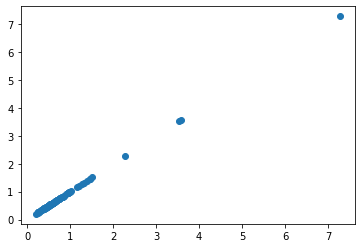

In [27]:
plt.scatter(y_crown, y_ibp)

In [ ]:
decomon_training.compile("adam", loss, metrics=["acc"])

In [13]:
def loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [14]:
decomon_training.compile("adam", loss, metrics=["acc"])

In [16]:
decomon_training.fit(B_train, Y_train, validation_split=0.2, batch_size=100, epochs=1)

373/480 [======================>.......] - ETA: 4:26 - loss: 0.1092 - acc: 7.2386e-04

KeyboardInterrupt: 

In [18]:
model.evaluate(x_train, y_train)

1875/1875 [==============================] - 2s 1ms/step - loss: 0.1900 - acc: 0.9597


[0.19000846147537231, 0.959683358669281]

In [9]:
from decomon import get_adv_box, get_adv_loss, get_model
from decomon.models import clone

In [10]:
convex_domain = {"name": "ball", "p": np.inf, "eps": max(0, 0.015)}

In [11]:
crown_ibp_ball = clone(model, method="crown-hybrid", convex_domain=convex_domain, finetune=False)

dense_1_NODE_140406930690000


In [12]:
crown_ibp_box = clone(model, method="crown-hybrid", finetune=False)

dense_1_NODE_140406930690000


In [13]:
from decomon import get_adv_box, get_adv_noise

In [14]:
# build robustness bounds
eps = 0.015
X_train = x_train
X_train_min = X_train - eps
X_train_max = X_train + eps
Y_train = y_train
B_train = np.concatenate([X_train_min[:, None], X_train_max[:, None]], 1)

X_test = x_test
X_test_min = X_test - eps
X_test_max = X_test + eps
Y_test = y_test
B_test = np.concatenate([X_test_min[:, None], X_test_max[:, None]], 1)

In [15]:
adv_ball = get_adv_noise(crown_ibp_ball, X_train[:10], Y_train[:10], eps=0.015, p=np.inf)

> /Users/ducoffe/Documents/Code/open_sourcing/Airbus/decomon/decomon/wrapper.py(1394)get_forward_score()
   1392             discard_mask_s = t_tensor_[:, :, None] * s_tensor_[:, None, :]
   1393             import pdb; pdb.set_trace()
-> 1394             upper -= (1 - discard_mask_s) * (const + 0.1)
   1395 
   1396             # upper = upper * s_tensor_[:, :, None] - (const + 0.1) * (1. - s_tensor_[:, None,:])

ipdb> c


In [16]:
adv_box = get_adv_box(crown_ibp_box, X_train_min[:10], X_train_max[:10], Y_train[:10])

In [17]:
adv_ball

array([  5.8751116, -10.699654 ,   2.2734857,  -1.7966409,  -1.1422157,
         1.4221632,   1.9635725, -14.461422 ,   9.086023 ,  -7.845304 ],
      dtype=float32)

In [18]:
adv_box

array([  5.8751116, -10.699671 ,   2.2734814,  -1.7966409,  -1.1422157,
         1.4221632,   1.9635725, -14.461422 ,   9.086023 ,  -7.845304 ],
      dtype=float32)

In [ ]:
def get_adv_noise(
    model,
    x,
    source_labels,
    eps=0,
    p=np.inf,
    target_labels=None,
    batch_size=-1,
    fast=True,
):

In [20]:
adv_model = get_model(crown_ibp)

In [21]:
adv_loss = get_adv_loss(crown_ibp, softmax=False)

In [22]:
adv_model.compile("adam", adv_loss)

In [24]:
# model.save_weights('tuto_4_ongoing.hd5')

In [25]:
adv_model.evaluate(B_train[:1], Y_train[0:1])

1/1 [==============================] - 0s 290ms/step - loss: 11.2815


11.281511306762695

In [21]:
adv_model.fit(B_train[:4], Y_train[:4], batch_size=10, epochs=10)

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: -1.2954
Epoch 2/10
1/1 [==============================] - 0s 225ms/step - loss: -4.2797
Epoch 3/10
1/1 [==============================] - 0s 218ms/step - loss: -4.7283
Epoch 4/10
1/1 [==============================] - 0s 216ms/step - loss: -7.8687
Epoch 5/10
1/1 [==============================] - 0s 215ms/step - loss: -4.4584
Epoch 6/10
1/1 [==============================] - 0s 208ms/step - loss: -5.5166
Epoch 7/10
1/1 [==============================] - 0s 215ms/step - loss: -4.5222
Epoch 8/10
1/1 [==============================] - 0s 253ms/step - loss: -5.4438
Epoch 9/10
1/1 [==============================] - 0s 239ms/step - loss: -6.1163
Epoch 10/10
1/1 [==============================] - 0s 214ms/step - loss: -6.9742


In [21]:
crown_hybrid = clone(model, method="crown-hybrid")

TypeError: Exception encountered when calling layer "decomon_minimum_1" (type DecomonMinimum).

in user code:

    File "../decomon/layers/decomon_merge_layers.py", line 286, in call  *
        output = maximum(
    File "../decomon/layers/utils.py", line 746, in maximum  *
        output_1 = relu_(
    File "../decomon/layers/utils.py", line 576, in relu_  *
        w_u_, b_u_, w_l_, b_l_ = get_linear_hull_relu(upper, lower, slope, **kwargs)
    File "../decomon/utils.py", line 425, in get_linear_hull_relu  *
        alpha_l_ = alpha_l[None]

    TypeError: 'bool' object is not subscriptable


Call arguments received:
  • inputs=['tf.Tensor(shape=(None, 2, 784), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 784, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 784, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 2, 784), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 784, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 784, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)']

In [27]:
adv_train = get_adv_box(crown_ibp, X_train_min[:10], X_train_max[:10], Y_train[:10])

In [28]:
adv_train

array([2.4867989e-04, 2.1810252e-03, 7.6253060e-04, 7.9125166e-06,
       5.0465483e-04, 2.2408454e-02, 7.9125166e-06, 2.8640870e-04,
       7.9125166e-06, 7.6253060e-04], dtype=float32)

In [ ]:
upper = get_adv_box(decomon_model, x_min, x_max, source_labels=source_label, n_sub_boxes=4)

In [11]:
adv_model.evaluate(B, Y)

  39/1875 [..............................] - ETA: 3:56 - loss: 1.0000

KeyboardInterrupt: 